In [1]:
import math
import matplotlib.pyplot as plt
import random
import numpy as np
import pandas as pd
from IPython import display
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, f1_score, precision_score
import seaborn as sns

# Data Generation

In [2]:
random.seed(42)
data = []

for i in range(500):
  x1 = random.randint(0,100)
  x2 = random.randint(0,100)
  y = 0

  if 0<=x1<=100 and 0<=x2<=20:
    y = [1,0,0,0,0]
  elif 0<=x1<=100 and 20<x2<=40:
    y = [0,1,0,0,0]
  elif 0<=x1<=100 and 40<x2<=60:
    y = [0,0,1,0,0]
  elif 0<=x1<=100 and 60<x2<=80:
    y = [0,0,0,1,0]
  elif 0<=x1<=100 and 80<x2<=100:
    y = [0,0,0,0,1]

  data.append([[x1, x2], y])

In [3]:
for i in range(10):
    print(data[i])

[[81, 14], [1, 0, 0, 0, 0]]
[[3, 94], [0, 0, 0, 0, 1]]
[[35, 31], [0, 1, 0, 0, 0]]
[[28, 17], [1, 0, 0, 0, 0]]
[[94, 13], [1, 0, 0, 0, 0]]
[[86, 94], [0, 0, 0, 0, 1]]
[[69, 11], [1, 0, 0, 0, 0]]
[[75, 54], [0, 0, 1, 0, 0]]
[[4, 3], [1, 0, 0, 0, 0]]
[[11, 27], [0, 1, 0, 0, 0]]


In [4]:
X = []
Y = []
for d in data:
  X.append(d[0])
  Y.append(d[1])

X = np.array(X)
Y = np.array(Y)

In [5]:
X_train = X[:400]
Y_train = Y[:400]
X_test = X[400:]
Y_test = Y[400:]

# Visual Representation of The Dataset

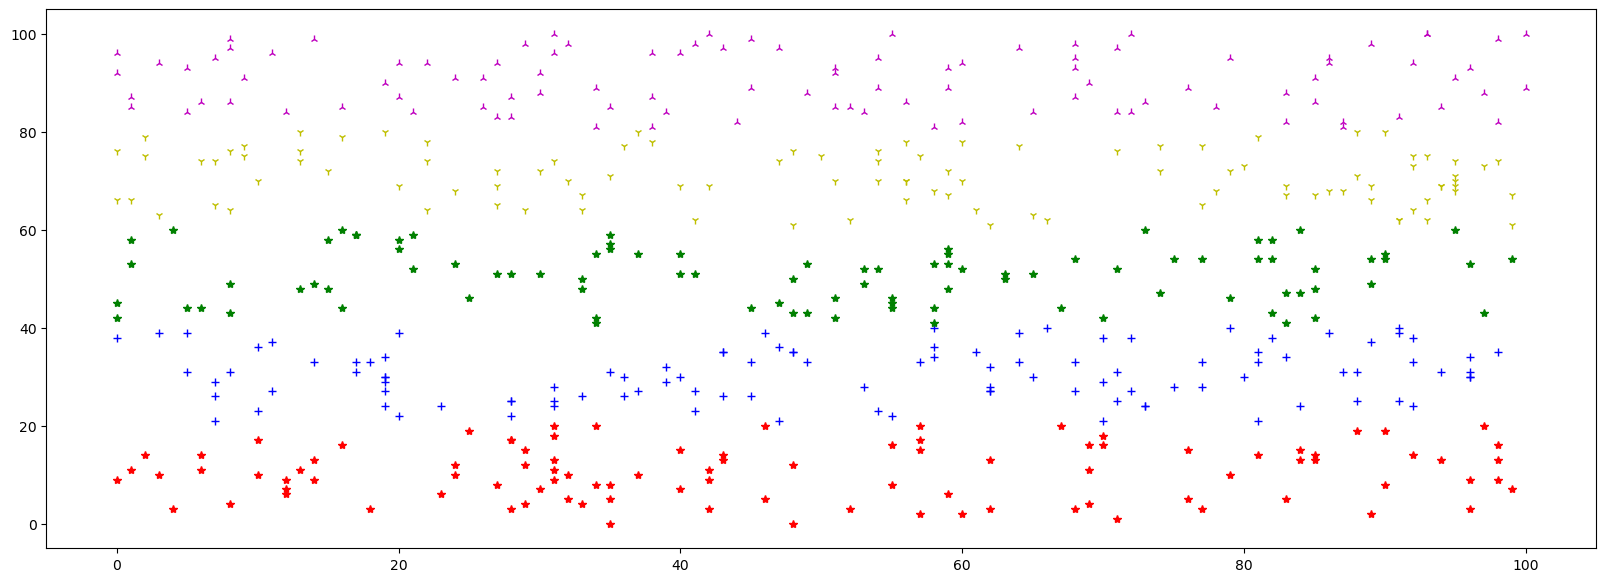

In [6]:
plt.figure(figsize=(20, 7))
for i in range(500):
  if Y[i][0] == 1:
    plt.plot(X[i][0], X[i][1], "r*")
  elif Y[i][1] == 1:
    plt.plot(X[i][0], X[i][1], "b+")
  elif Y[i][2] == 1:
    plt.plot(X[i][0], X[i][1], "g*")
  elif Y[i][3] == 1:
    plt.plot(X[i][0], X[i][1], "y1")
  elif Y[i][4] == 1:
    plt.plot(X[i][0], X[i][1], "m2")

plt.show()

# Neural Network with ReLU and Softmax Activation

In [7]:
class NeuralNetwork(object):
    def __init__(self, hiddenLayer1Neurons=10, hiddenLayer2Neurons=10, hiddenLayer3Neurons=10, learningRate=0.01):
        inputLayerNeurons = 2
        outLayerNeurons = 5

        self.learning_rate = learningRate
        self.W_H1 = np.random.randn(inputLayerNeurons, hiddenLayer1Neurons) * 0.01
        self.W_H2 = np.random.randn(hiddenLayer1Neurons, hiddenLayer2Neurons) * 0.01
        self.W_H3 = np.random.randn(hiddenLayer2Neurons, hiddenLayer3Neurons) * 0.01
        self.W_O = np.random.randn(hiddenLayer3Neurons, outLayerNeurons) * 0.01

        self.B_H1 = np.zeros(hiddenLayer1Neurons)
        self.B_H2 = np.zeros(hiddenLayer2Neurons)
        self.B_H3 = np.zeros(hiddenLayer3Neurons)
        self.B_O = np.zeros(outLayerNeurons)

    def relu(self, x, der=False):
        if der:
            return np.where(x > 0, 1, 0)
        else:
            return np.maximum(0, x)

    def softmax(self, x):
        exp_values = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_values / np.sum(exp_values, axis=1, keepdims=True)

    def feedForward(self, X):
        hidden1_input = np.dot(X, self.W_H1) + self.B_H1
        self.hidden1_output = self.relu(hidden1_input)

        hidden2_input = np.dot(self.hidden1_output, self.W_H2) + self.B_H2
        self.hidden2_output = self.relu(hidden2_input)

        hidden3_input = np.dot(self.hidden2_output, self.W_H3) + self.B_H3
        self.hidden3_output = self.relu(hidden3_input)

        output_input = np.dot(self.hidden3_output, self.W_O) + self.B_O
        pred = self.softmax(output_input)
        return pred

    def backPropagation(self, X, Y, pred):
        output_error = pred - Y
        output_delta = self.learning_rate * output_error

        hidden3_error = output_delta.dot(self.W_O.T)
        hidden3_delta = self.learning_rate * hidden3_error * self.relu(self.hidden3_output, der=True)

        hidden2_error = hidden3_delta.dot(self.W_H3.T)
        hidden2_delta = self.learning_rate * hidden2_error * self.relu(self.hidden2_output, der=True)

        hidden1_error = hidden2_delta.dot(self.W_H2.T)
        hidden1_delta = self.learning_rate * hidden1_error * self.relu(self.hidden1_output, der=True)
        
        
         # Update weights
        self.W_H1 += X.T.dot(hidden1_delta)
        self.W_H2 += self.hidden1_output.T.dot(hidden2_delta)
        self.W_H3 += self.hidden2_output.T.dot(hidden3_delta)
        self.W_O += self.hidden3_output.T.dot(output_delta)

        # Update Biases
        self.B_H1 += self.learning_rate * np.sum(hidden1_delta, axis=0)
        self.B_H2 += self.learning_rate * np.sum(hidden2_delta, axis=0)
        self.B_H3 += self.learning_rate * np.sum(hidden3_delta, axis=0)
        self.B_O += self.learning_rate * np.sum(output_delta, axis=0)


    def train(self, X, Y):
        output = self.feedForward(X)
        self.backPropagation(X, Y, output)



# Training the Neural Network and Monitoring Cross-Entropy Loss Over Iterations

In [8]:
def cross_entropy_loss(pred, Y):
    epsilon = 1e-10
    pred = np.clip(pred, epsilon, 1. - epsilon)
    return -np.mean(np.sum(Y * np.log(pred), axis=1))

Epoch: 0, error: 1.6094058801057616
Epoch: 1000, error: 1.607322220893228
Epoch: 2000, error: 1.605072105093809
Epoch: 3000, error: 0.7097037784245938
Epoch: 4000, error: 0.32234949916568084
Epoch: 5000, error: 0.24081398826006478
Epoch: 6000, error: 0.18818340918570037
Epoch: 7000, error: 0.15726506938907772
Epoch: 8000, error: 0.13743607727467919
Epoch: 9000, error: 0.12393636897126292


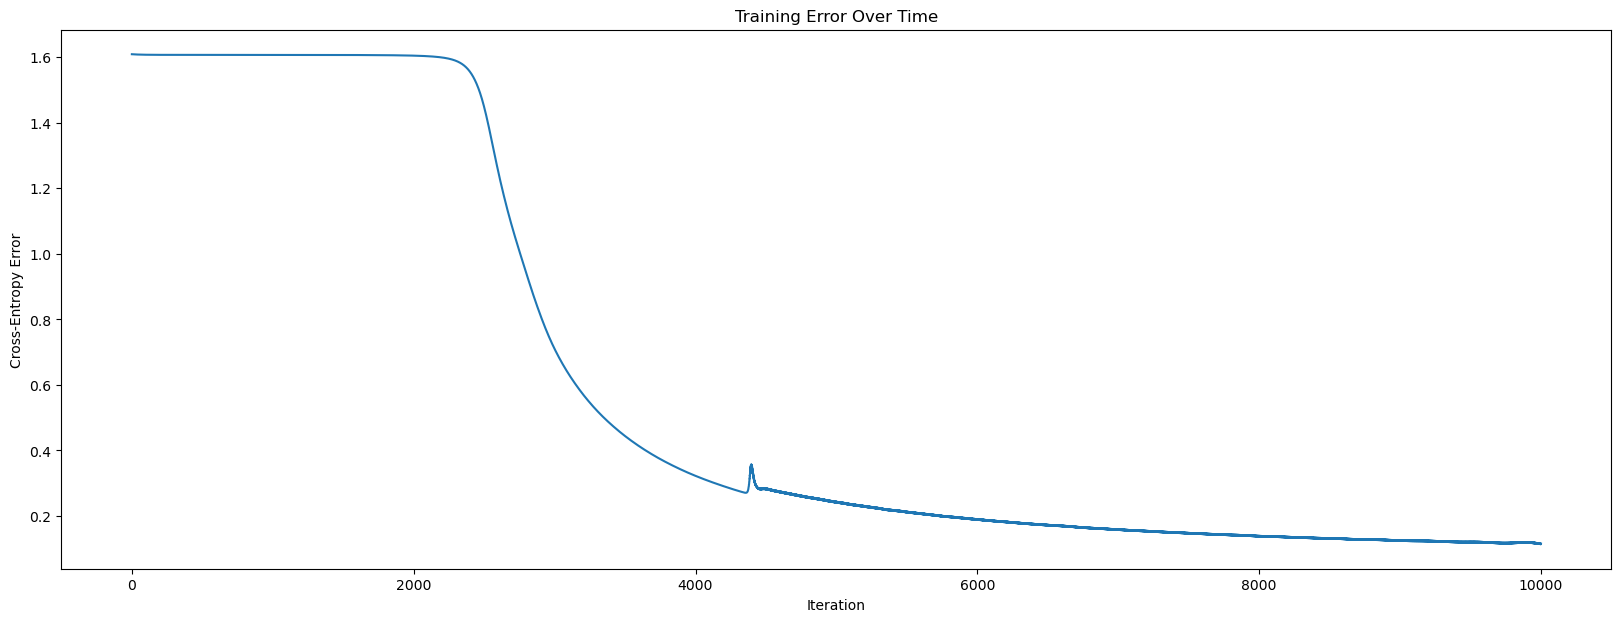

In [9]:
NN = NeuralNetwork()

err = []
for i in range(10000):
    NN.train(X_train, Y_train)
    err.append(cross_entropy_loss(NN.feedForward(X_train), Y_train))

    if i % 1000 == 0:
        print(f'Epoch: {i}, error: {err[i]}')

plt.figure(figsize=(20, 7))
plt.plot(err)
plt.xlabel('Iteration')
plt.ylabel('Cross-Entropy Error')
plt.title('Training Error Over Time')
plt.show()


# Predict Class for Random a Sample

In [10]:
# Returns probability of all classes
def getProb(pred):
    return {f'Class-{index}': p*100 for index, p in enumerate(pred)}

In [11]:
# returns the highest probablity
def getClass(dict):
  max_key = max(dict, key=dict.get)
  return (max_key)

In [12]:
pred = NN.feedForward([[50, 30]])
print(pred)
print(getProb(pred[0]))
print(getClass(getProb(pred[0])))

[[5.99929172e-05 9.96794993e-01 3.14501341e-03 8.33601852e-10
  9.23070072e-21]]
{'Class-0': 0.005999291724493403, 'Class-1': 99.67949928429209, 'Class-2': 0.3145013406232268, 'Class-3': 8.336018522951813e-08, 'Class-4': 9.230700719211705e-19}
Class-1


# Performance Metrics

In [13]:
predictions = NN.feedForward(X_test)

Y_true = np.argmax(Y_test, axis=1)
Y_pred = np.argmax(predictions, axis=1)

accuracy = accuracy_score(Y_true, Y_pred)
precision = precision_score(Y_true, Y_pred, average = None)
recall = recall_score(Y_true, Y_pred, average = 'macro')
f1 = f1_score(Y_true, Y_pred, average = 'macro')

for i in range(5):
    print(f"Class {i}: Precision: {precision[i]}")

print(f"Overall accuracy: {accuracy}")
print(f"Overall Recall: {recall}")
print(f"Overall F1 Score: {f1}")
print(f"Overall Precision: {np.average(precision)}")


Class 0: Precision: 1.0
Class 1: Precision: 1.0
Class 2: Precision: 0.9545454545454546
Class 3: Precision: 1.0
Class 4: Precision: 0.8846153846153846
Overall accuracy: 0.96
Overall Recall: 0.96
Overall F1 Score: 0.9608817170278965
Overall Precision: 0.9678321678321679


# Documentation

Modifications made:As previous Neural Network was for 2 distinct classes with 2 hidden layer, some modifications are made for the 3 hidden layer with 5 distinct classes. Such as -

1.outLayerNeurons value changed from 2 to 5 for accomodating 5 seperate classes.

2.Added a variable to hold the 2nd and 3rd hidden layer neuron counts: hidden2LayerNeurons & hidden2LayerNeurons respectively.
    
3.Additional 2 weight matrices were introduced to handle the weights between Hidden1-Hidden2 & Hidden2-Hidden3 connections: W_H2, W_H3.
    
4.For handling biases a biases list was constructed, which contained lists of varying sizes, where the sizes vary with the number of neurons in each layer.

5.Added two new activation functions,ReLU & softmax.ReLU is used to introduce non-linearity and avoid vanishing gradients in hidden layers, while softmax is used in the output layer to convert the network's outputs into probability distributions across multiple classes.

6.During forward propagation, 4 new calculated terms were needed, hidden2_input, hidden2_output, hidden3_input, hidden3_output. These were added for the additional 2 hidden layers to the network.
 In the same way, during backpropagation, hidden3_error, hidden2_error, hidden3_delta, hidden2_delta were introduced.

7.Due to our new addition of baises, they also needed to be adjusted accordingly.

Challenges:

1.Adding 2 additional layers to the model required extra calculations and code to be implemented which proved to be difficult at the time.

2.Calculating the backpropagation formula along with the weight, bias adjustments lead to mistakes during the initial stages but were soon remedied.

3.Difficulities were faced while visualizing the results.

# Result & Analysis

In [14]:
# Confusion matrix
def conf_matrix(Y_true, Y_pred, c = 'magma'):
  conf_matrix = confusion_matrix(Y_true, Y_pred)
  print("Confusion Matrix:")
  print(conf_matrix)

  plt.figure(figsize=(10, 7))
  sns.heatmap(conf_matrix, annot=True, fmt='d', cmap=c)
  plt.xlabel('Predicted')
  plt.ylabel('True')
  plt.title('Confusion Matrix')
  plt.show()

Confusion Matrix:
[[14  0  0  0  0]
 [ 0 22  0  0  0]
 [ 0  0 21  0  0]
 [ 0  0  1 16  3]
 [ 0  0  0  0 23]]


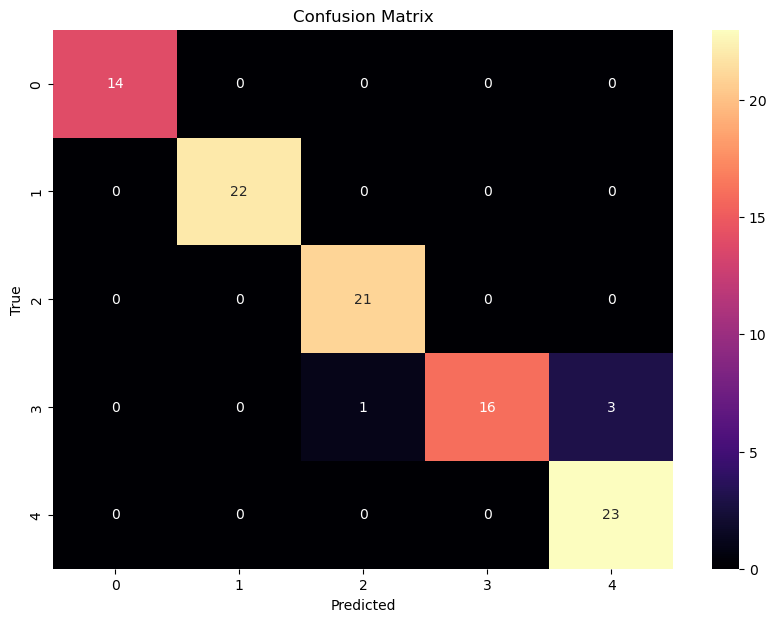

In [15]:
conf_matrix(Y_true, Y_pred)

# Insights:

1.The neural network effectively learned to categorize the synthetic dataset into five distinct classes.

2.The softmax activation function and cross-entropy loss proved efficient in managing the multi-class classification task.

3.The reduction in training loss over the epochs shows that the model was successfully learning.

# After Changing Parameters

Epoch: 0, error: 1.609396092937958
Epoch: 1000, error: 0.7007678629106527
Epoch: 2000, error: 0.3974334894799405
Epoch: 3000, error: 0.2953992278045735
Epoch: 4000, error: 0.249086565790684
Epoch: 5000, error: 0.21370318881872527
Epoch: 6000, error: 0.18289315025442335
Epoch: 7000, error: 0.16171621511081846
Epoch: 8000, error: 0.14463118651692847
Epoch: 9000, error: 0.13166425151073022


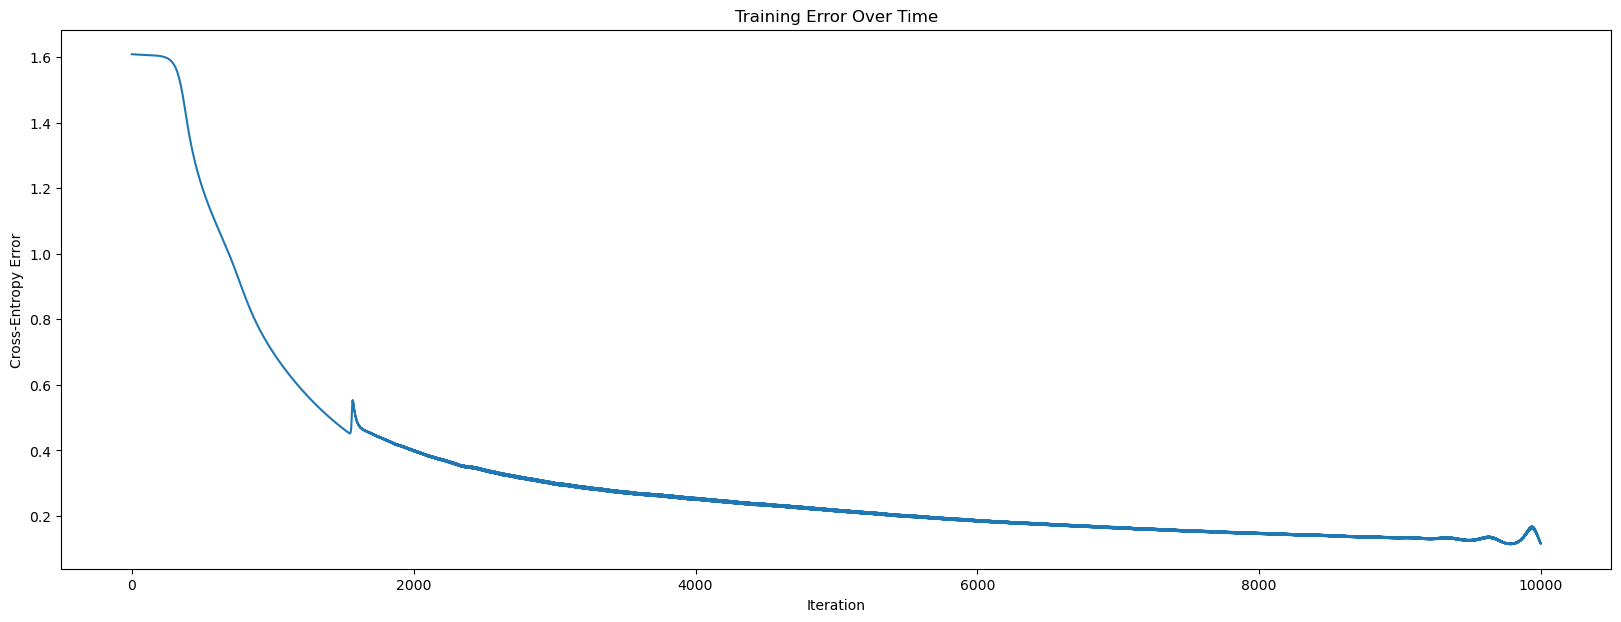

In [16]:
new_nn = NeuralNetwork(hiddenLayer1Neurons=40, hiddenLayer2Neurons=40, hiddenLayer3Neurons=40, learningRate=0.01)
err = []
for i in range(10000):
    new_nn.train(X_train, Y_train)
    err.append(cross_entropy_loss(new_nn.feedForward(X_train), Y_train))

    if i % 1000 == 0:
        print(f'Epoch: {i}, error: {err[i]}')

plt.figure(figsize=(20, 7))
plt.plot(err)
plt.xlabel('Iteration')
plt.ylabel('Cross-Entropy Error')
plt.title('Training Error Over Time')
plt.show()


In [17]:
predictions1 = new_nn.feedForward(X_test)

Y_true1 = np.argmax(Y_test, axis=1)
Y_pred1 = np.argmax(predictions1, axis=1)

Confusion Matrix:
[[14  0  0  0  0]
 [ 0 22  0  0  0]
 [ 0  0 21  0  0]
 [ 0  0  0 17  3]
 [ 0  0  0  0 23]]


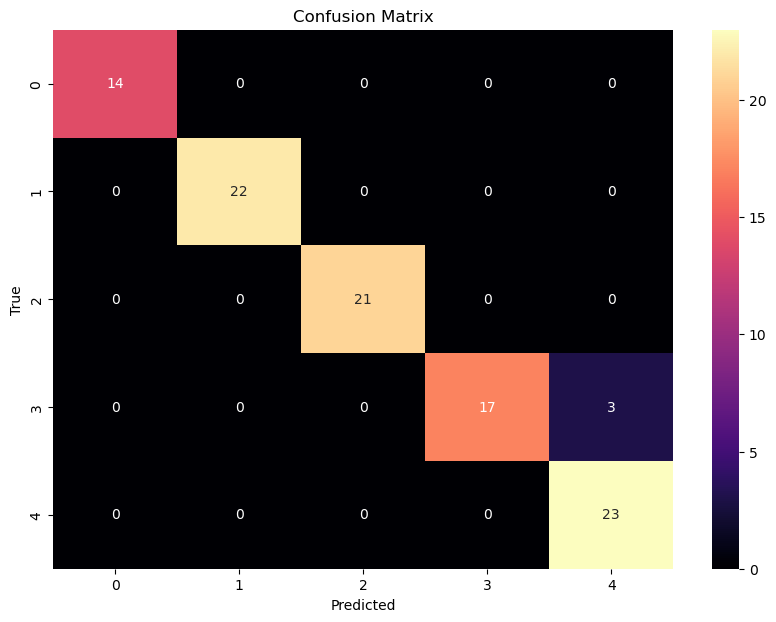

In [18]:
conf_matrix(Y_true1, Y_pred1)

In [19]:
accuracy = accuracy_score(Y_true1, Y_pred1)
precision = precision_score(Y_true1, Y_pred1, average = None)
recall = recall_score(Y_true1, Y_pred1, average = 'macro')
f1 = f1_score(Y_true1, Y_pred1, average = 'macro')

for i in range(5):
    print(f"Class {i}: Precision: {precision[i]}")

print(f"Overall accuracy: {accuracy}")
print(f"Overall Recall: {recall}")
print(f"Overall F1 Score: {f1}")
print(f"Overall Precision: {np.average(precision)}")

Class 0: Precision: 1.0
Class 1: Precision: 1.0
Class 2: Precision: 1.0
Class 3: Precision: 1.0
Class 4: Precision: 0.8846153846153846
Overall accuracy: 0.97
Overall Recall: 0.97
Overall F1 Score: 0.9715388858246001
Overall Precision: 0.976923076923077


# Comparizon

When each hidden layer has 10 neurons and the learning rate was was 0.01,

Accuracy : 96%
,Recall : 96%
,F1 score : 96%
,Precision : 97%

When each hidden layer has 40 neurons each and the learning rate was was 0.01,

Accuracy : 97%
,Recall : 97%
,F1 score : 97%
,Precision : 97%
    
Increasing the number of neurons in each hidden layer from 10 to 40 while keeping the learning rate constant at 0.01 led to a slight
improvement in accuracy, recall, and F1 score, with precision remaining stable at 97%.This suggests that a more complex model with 
additional neurons provided a marginally better performance on the classification task.

# Conclusion

Summary:The neural network was designed to classify a synthetic dataset into five distinct classes. The dataset was generated with specific conditions, where the input space was divided into five equal intervals, each corresponding to a different class. The network architecture included three hidden layers, each using ReLU activation, and a softmax output layer to produce probability distributions across the five classes. The model was trained using cross-entropy loss, and its performance was evaluated using accuracy, precision, recall, F1 score, and a confusion matrix.

Two sets of experiments were conducted: one with 10 neurons in each hidden layer and the other with 40 neurons. The results showed that increasing the number of neurons led to a slight improvement in overall performance metrics, demonstrating the impact of model complexity on classification tasks.


Challenges and lessons:The model faced difficulties when the class labels were numerical, as this led to the formation of unintended patterns and resulted in significant errors. This issue was resolved by applying one-hot encoding.


Further Improvements:In this neural network, the softmax activation function was used in the output layer, and ReLU was applied in the hidden layers. However, alternative ReLU variants like Leaky ReLU or ELU could potentially enhance performance. Additionally, adjusting the learning rate and the number of neurons in the hidden layers might lead to further improvements.